In [1]:
#! Python3
# by Jacob Kovach
# Confidential and Proprietary

import numpy as np, pandas as pd, urllib.request, spacy, pickle, re
from string import punctuation
from datetime import datetime, timedelta
from collections import Counter
from nltk import tokenize
from nltk.corpus import stopwords
from pandas_datareader import DataReader
from tqdm import tqdm

# Sets number of files used in training the model
file_no = 500

# Read call links from the index file
call_links = []
with open ('/Users/jkovach/Downloads/earnings-call-transcripts/_index.txt', 'r') as index:
    urls = index.readlines()
    for line in urls:
        url = line
        if len(call_links) >= file_no:
            break
        else:
            call_links.append(url)
        if len(call_links) % 500 == 0:
            print("Files Read: {}".format(len(call_links)))

# Create initial dataset
call_df = pd.DataFrame()
call_df['date_string'] = np.asarray([link[47:57] for link in call_links])
call_df['datetime'] = np.asarray(pd.to_datetime(call_df['date_string'], errors='coerce', format='%Y/%m/%d'))
call_df['filename'] = np.asarray([link[58:-6] for link in call_links])
call_df = call_df.drop('date_string', 1)
call_df.head()

Files Read: 500


,datetime,filename
0,2017-10-11,barracuda-networks-q2-2018-earnings-conference...
1,2017-10-12,delta-air-lines-q3-2017-earnings-conference-ca...
2,2017-10-12,jp-morgan-chase-co-q3-2017-earnings-conference...
3,2017-10-13,citigroup-q3-2017-earnings-conference-call-tra...
4,2017-10-16,bank-of-america-corporation-q3-2017-earnings-c...


In [2]:
# Define nlp dictionary and folder location for transcripts
nlp = spacy.load('en')
root = '/Users/jkovach/Downloads/earnings-call-transcripts/'

# Regex objects
ticker_re = re.compile(r'\:[A-Z]+\)')
dur_re = re.compile(r'(Duration: )(\d+)')
chars = (punctuation + '0123456789').replace('-', '')

# Define functions for getting and cleaning text, ticker, duration, etc. 
def text_cleaner(f):
    filepath = root + f + '.txt'
    # Open file and read text
    try:
        with open (filepath, 'r') as tf:
            raw_text = tf.read()
            
    except:
        raw_text = ""

    # Text cleaning processes
    content = re.sub(r'([a-z0-9][\.:\?]?)([A-Z])', r'\1\n\2', raw_text)
    content = re.sub(r'www\.\S+\.com', '', content)
    content = re.sub(r'--', '', content)
    content = re.sub(r'\[.*\]', '', content)
    content = '\n\n'.join([sent for sent in content.split('\n') if len(sent.split())>10])
    content = ' '.join([token.lemma_ for token in nlp(content) if not token.is_stop and not token.is_punct])
    content = ' '.join([word for word in content.split() if not word.istitle() and word.isalpha()])
    content = re.sub(r'[A-Z]{2,}', '', content)
        
    return raw_text, content

def get_length(text):
    return len(text.split())

def get_duration(raw):
    try:
        duration = dur_re.search(raw).group(2)
    except:
        duration = np.nan
    return duration

def get_ticker(raw):
    ts=""
    for sent in tokenize.sent_tokenize(raw)[0:2]:
        try:
            ts += ticker_re.search(sent).group()
        except:
            ts=ts
    return ts[1:-1]

# Utility function to get 7-day movement of stock, beginning the day before the call
def price_delta(ticker, date):
    s = date - timedelta(days=3)
    e = date + timedelta(days=10)
    stock_df = DataReader(ticker, "yahoo", s, e).reset_index()
    cur_date_index = stock_df[stock_df['Date'] == date].index[0]
    min1 = stock_df.loc[cur_date_index-1, 'Close']
    plus7 = stock_df.loc[cur_date_index+5, 'Close']
    delta7 = ((plus7 - min1)/min1)*100
    return delta7

# Bin price_delta into categories as outcome of interest
def change_type(change_ratio):
    if change_ratio >= 4:
        return 2
    elif change_ratio <= -4:
        return 0
    else:
        return 1

# Apply functions to dataset 
tqdm.pandas(position=0, leave=True)
call_df['raw'], call_df['content'] = zip(*call_df['filename'].progress_apply(text_cleaner))
call_df['raw_len'] = call_df['raw'].apply(get_length)
call_df['clean_len'] = call_df['content'].apply(get_length)
call_df['duration'] = call_df['raw'].apply(get_duration)
call_df['ticker'] = call_df['raw'].apply(get_ticker)

for i in range(call_df.shape[0]):
    try:
        call_df.loc[i, 'price_delta'] = price_delta(call_df.loc[i, 'ticker'], call_df.loc[i, 'datetime'])
        if i % 100 == 0:
            print("Processing Row: ", i)
        
    except:
        call_df.loc[i, 'price_delta'] = np.nan

call_df['Movement'] = call_df['price_delta'].apply(change_type)
call_df = call_df.dropna().reset_index(drop=True)
call_df.head()

/Users/jkovach/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 500/500 [09:12<00:00,  1.11s/it]


Processing Row:  100
Processing Row:  200
Processing Row:  300
Processing Row:  400


,datetime,filename,raw,content,raw_len,clean_len,duration,ticker,price_delta,Movement
0,2017-10-12,delta-air-lines-q3-2017-earnings-conference-ca...,\n\nImage source: The Motley Fool.\n\nDelta Ai...,lady gentleman stand begin good morning welcom...,10703,3757,61,DAL,-1.507442,1
1,2017-10-12,jp-morgan-chase-co-q3-2017-earnings-conference...,\n\nImage source: The Motley Fool.\n\nJP Morga...,stand begin good morning lady gentleman welcom...,9822,3766,74,JPM,1.311446,1
2,2017-10-13,citigroup-q3-2017-earnings-conference-call-tra...,\n\nImage source: The Motley Fool.\n\nCitigrou...,hello welcome quarter earning review today hos...,12773,4684,82,C,1.602869,1
3,2017-10-16,bank-of-america-corporation-q3-2017-earnings-c...,\n\nImage source: The Motley Fool.\n\nBank of ...,good day welcome announcement time participant...,15511,6044,94,BAC,5.149051,2
4,2017-10-16,wells-fargo-q3-2017-earnings-conference-call-t...,\n\nImage source: The Motley Fool.\n\nWells Fa...,good morning conference operator today time li...,16286,6117,94,WFC,2.272306,1


,raw_len,clean_len,price_delta,Movement
count,426.000000,426.000000,426.000000,426.000000
mean,9272.753521,3435.617371,-0.094554,0.969484
std,2407.167667,882.846992,8.431649,0.683595
min,3210.000000,1134.000000,-40.962229,0.000000
25%,7859.250000,2869.250000,-3.922844,1.000000
50%,9407.500000,3526.500000,-0.123820,1.000000
75%,10533.000000,3925.750000,3.263449,1.000000
max,19555.000000,6980.000000,77.448078,2.000000


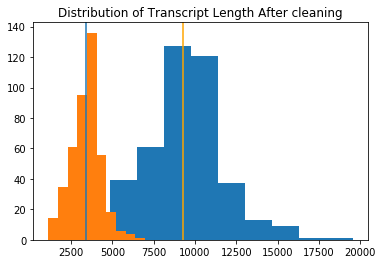

In [14]:
# Check central tendency of word length of transcripts
plt.figure()
plt.hist(call_df.raw_len)
plt.axvline(call_df.raw_len.mean(), color='orange')
plt.title('Distribution of Raw Transcript Length')

plt.hist(call_df.clean_len)
plt.title('Distribution of Transcript Length After cleaning')
plt.axvline(call_df.clean_len.mean())
plt.show

call_df.describe()

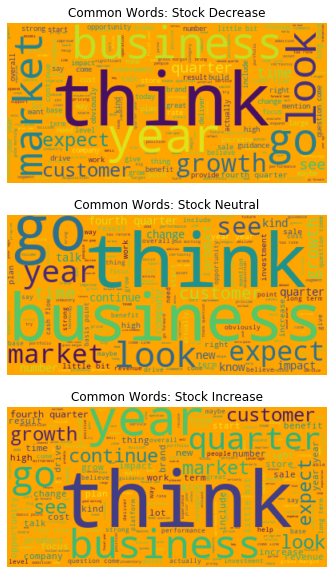

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create corpus of words from cleaned docs, one corpus for each class of stock movement
corpus_down = ' '.join(list(call_df[call_df['Movement']==0]['content'])).split()
corpus_n = ' '.join(list(call_df[call_df['Movement']==1]['content'])).split()
corpus_up = ' '.join(list(call_df[call_df['Movement']==2]['content'])).split()

# Visualize word clouds for each group
down_wc = WordCloud(background_color='orange').generate(' '.join(corpus_down))
n_wc = WordCloud(background_color='orange').generate(' '.join(corpus_n))
up_wc = WordCloud(background_color='orange').generate(' '.join(corpus_up))

plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.imshow(down_wc, interpolation='bilinear')
plt.title('Common Words: Stock Decrease')
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(n_wc, interpolation='bilinear')
plt.title('Common Words: Stock Neutral')
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(up_wc, interpolation='bilinear')
plt.title('Common Words: Stock Increase')
plt.axis('off')
plt.show()

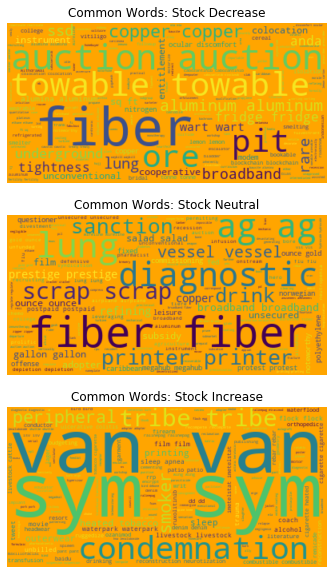

In [15]:
# Get set of all words (remove duplicate words)
corpus_all = set(corpus_down + corpus_n + corpus_up)

# Create a list of words common between all docs
common_words = []
for word in corpus_all:
    if word in corpus_down and word in corpus_n and word in corpus_up:
        common_words.append(word)

# Utility function to create unique words for each stock movement class
def remove_common_words(corpus):
    unique_words = []
    for word in corpus:
        if word not in common_words:
            unique_words.append(word)
    
    return unique_words

# Create wordclouds for unique words in each class of movement
down_unique_wc = WordCloud(background_color='orange').generate(' '.join(remove_common_words(corpus_down)))
n_unique_wc = WordCloud(background_color='orange').generate(' '.join(remove_common_words(corpus_n)))
up_unique_wc = WordCloud(background_color='orange').generate(' '.join(remove_common_words(corpus_up)))

# Visualize terms without common words
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.imshow(down_unique_wc, interpolation='bilinear')
plt.title('Common Words: Stock Decrease')
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(n_unique_wc, interpolation='bilinear')
plt.title('Common Words: Stock Neutral')
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(up_unique_wc, interpolation='bilinear')
plt.title('Common Words: Stock Increase')
plt.axis('off')

plt.show()

In [6]:
# Save df to file
def save_files(var, f):
    with open (f, 'wb') as file:
        pickle.dump(var, file)

save_files(call_df, '/Users/jkovach/Downloads/earnings-call-transcripts/_call_df_' + str(file_no))
save_files(common_words, '/Users/jkovach/Downloads/earnings-call-transcripts/_common_word_list_' + str(file_no))
call_df.head()

,datetime,filename,raw,content,raw_len,clean_len,duration,ticker,price_delta,Movement
0,2017-10-12,delta-air-lines-q3-2017-earnings-conference-ca...,\n\nImage source: The Motley Fool.\n\nDelta Ai...,lady gentleman stand begin good morning welcom...,10703,3757,61,DAL,-1.507442,1
1,2017-10-12,jp-morgan-chase-co-q3-2017-earnings-conference...,\n\nImage source: The Motley Fool.\n\nJP Morga...,stand begin good morning lady gentleman welcom...,9822,3766,74,JPM,1.311446,1
2,2017-10-13,citigroup-q3-2017-earnings-conference-call-tra...,\n\nImage source: The Motley Fool.\n\nCitigrou...,hello welcome quarter earning review today hos...,12773,4684,82,C,1.602869,1
3,2017-10-16,bank-of-america-corporation-q3-2017-earnings-c...,\n\nImage source: The Motley Fool.\n\nBank of ...,good day welcome announcement time participant...,15511,6044,94,BAC,5.149051,2
4,2017-10-16,wells-fargo-q3-2017-earnings-conference-call-t...,\n\nImage source: The Motley Fool.\n\nWells Fa...,good morning conference operator today time li...,16286,6117,94,WFC,2.272306,1
